In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [4]:
session_info = {'date': "15_04_2024",
                'genotype_dir': "ER4d_sytjGCaMP7f_Chrimson88tdT",
                'fly': 'fly2',
                'session': 'baseline-000',
                'full_genotype': '10xUASChrimson88::tdT/+; +ER4d-AD/+; UASsytjGCaMP7f^attp2/ER4d-DBD SS00238',
                'ecl date': '4/6-7/2024',
                'notes': ''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)




In [5]:
pp.extract_metadata()
pp.bruker_to_h5(overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
nap = pp.open_napari()

(209, 341)
[                                        ] | 0% Completed | 634.32 ms

<tifffile.TiffFile 'baseline-000_Cyc…_000003.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


[########################################] | 100% Completed | 45.71 s


In [6]:
print()

In [15]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)
y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)

In [16]:
pp.save()

In [17]:
if False:
    n_rois=16
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
   

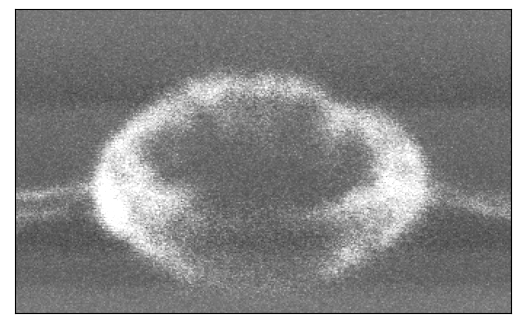

In [18]:
fig,ax = plt.subplots()
im = np.mean(pp.ref_img[0,:,:,:],axis=0)
ax.imshow(im,cmap='Greys_r', vmax=np.percentile(im,99), vmin=-10)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/ex_vivo_pilot/puff_img.pdf')

In [19]:
y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)
# y= sp.ndimage.median_filter(y,(1,1,3))-1

In [20]:
print(pp.voltage_recording_aligned.columns)

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')


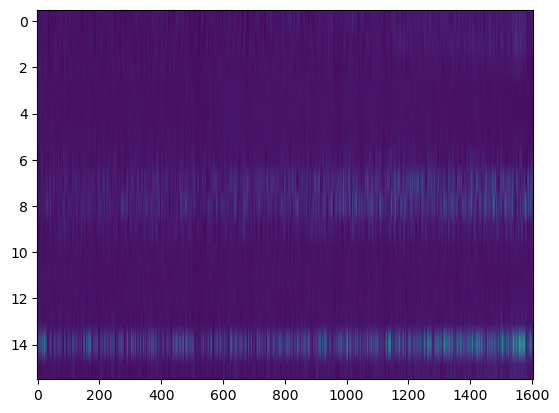

In [21]:
fig, ax = plt.subplots()
ax.imshow(y[1,:,:],aspect='auto')

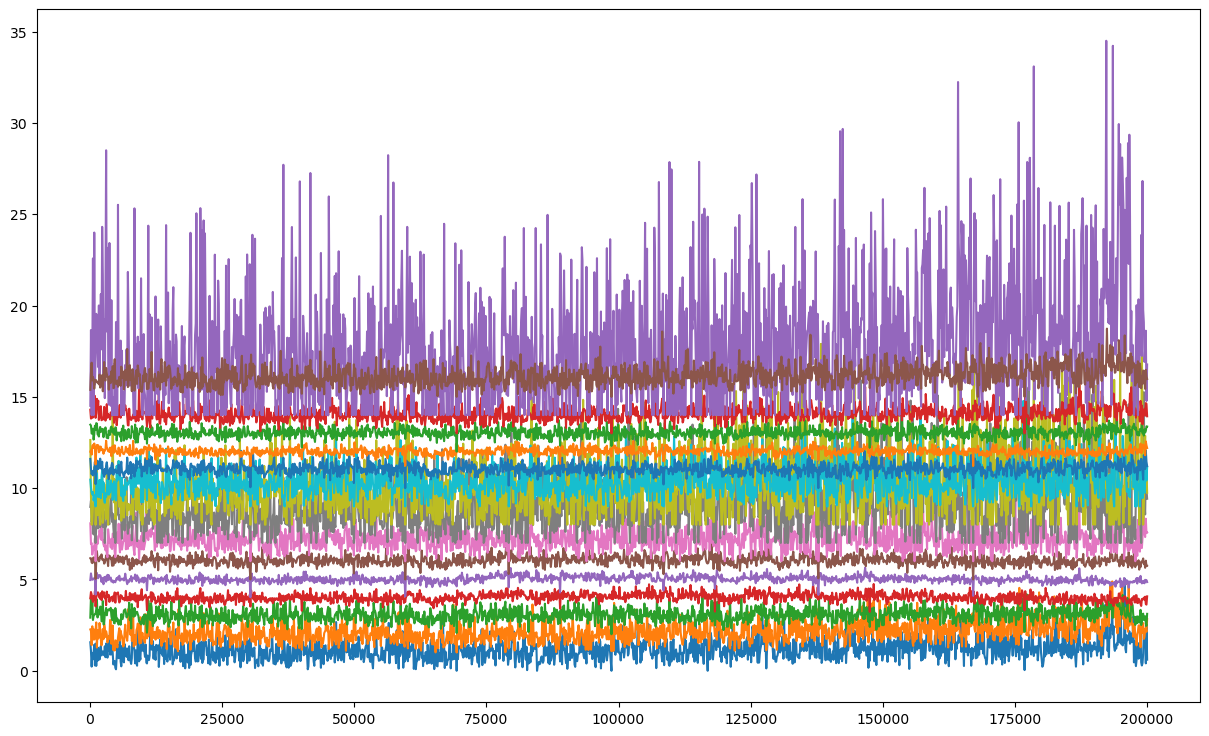

In [22]:
fig, ax = plt.subplots(figsize= [15,9])
x = pp.voltage_recording_aligned['Time(ms)'].to_numpy()
for r in range(n_rois):
    ax.plot(x, y[1,r,:]+r)

KeyError: ' Pump Trigger'

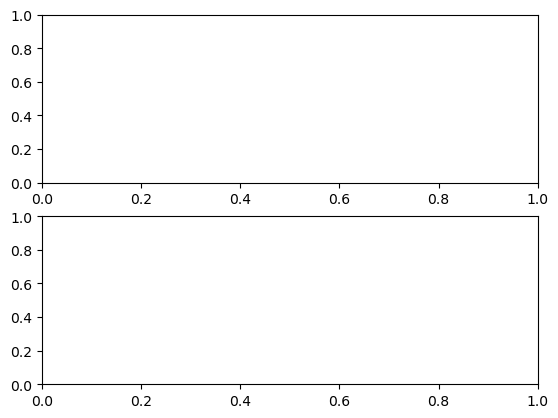

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(pp.voltage_recording_aligned[' Pump Trigger'])
_pump_trigger = 1*(pp.voltage_recording_aligned[' Pump Trigger'].to_numpy()>1000)
pump_trigger = np.zeros_like(_pump_trigger)
pump_trigger[1:] = 1*(_pump_trigger[:-1]>_pump_trigger[1:])
ax[1].plot(pump_trigger)

In [ ]:
# %matplotlib qt
fig, ax = plt.subplots(2,1)
ax[0].plot(pp.voltage_recording_aligned[' Opto Trigger'])
_opto_trigger = 1*(pp.voltage_recording_aligned[' Opto Trigger'].to_numpy()>1000)
opto_trigger = np.zeros_like(_opto_trigger)
opto_trigger[1:] = 1*(_opto_trigger[1:]>_opto_trigger[:-1])
ax[1].plot(opto_trigger)

In [10]:
opto_trig_inds = np.argwhere(opto_trigger==1).ravel()
y[:,:,opto_trig_inds]=np.nan
y[:,:,opto_trig_inds+1]=np.nan
y[:,:,opto_trig_inds-1]=np.nan

pre_inds = opto_trig_inds[:10]
pair_inds = opto_trig_inds[10:15]
post_inds = opto_trig_inds[15:]

print(pre_inds.shape, pair_inds.shape, post_inds.shape)

(10,) (5,) (10,)


In [11]:
dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']

In [12]:
t = np.arange(-10*dt, 50*dt+1E-3, dt)
pre_resp = np.zeros((pre_inds.shape[0], n_rois, t.shape[0]))
for i, ind in enumerate(pre_inds):
    pre_resp[i,:,:] = y[1,:, ind-10:ind+51]
pre_resp -= pre_resp[:,:,:9].mean(axis=-1,keepdims=True)
    
pair_resp = np.zeros((pair_inds.shape[0], n_rois, t.shape[0]))
for i, ind in enumerate(pair_inds):
    pair_resp[i,:,:] = y[1,:, ind-10:ind+51]
pair_resp -= pair_resp[:,:,:9].mean(axis=-1,keepdims=True)    

post_resp = np.zeros((post_inds.shape[0], n_rois, t.shape[0]))
for i, ind in enumerate(post_inds):
    post_resp[i,:,:] = y[1,:, ind-10:ind+51]
post_resp -= post_resp[:,:,:9].mean(axis=-1,keepdims=True)

/tmp/ipykernel_924899/1078655347.py:2: RuntimeWarning: Mean of empty slice
  ax[0].imshow(np.nanmean(pre_resp, axis=0))


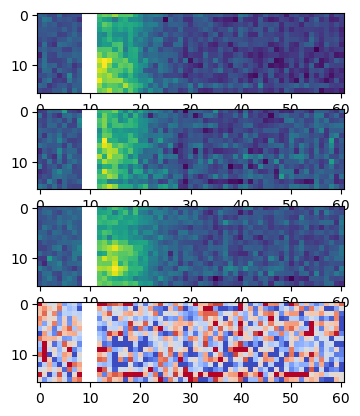

In [13]:

fig, ax= plt.subplots(4,1)
ax[0].imshow(np.nanmean(pre_resp, axis=0))
ax[1].imshow(pair_resp.mean(axis=0))
ax[2].imshow(post_resp.mean(axis=0))
ax[3].imshow(pre_resp.mean(axis=0)-post_resp.mean(axis=0), vmin=-.1, vmax=.1, cmap='coolwarm')



# for i in range(pre_resp.shape[0]):
#     fig, ax = plt.subplots()
#     ax.imshow(pre_resp[i,:,:])

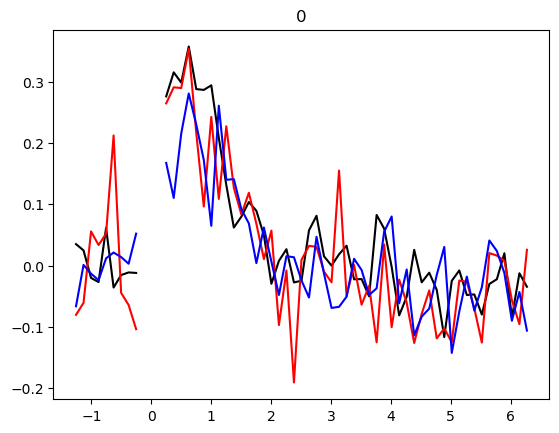

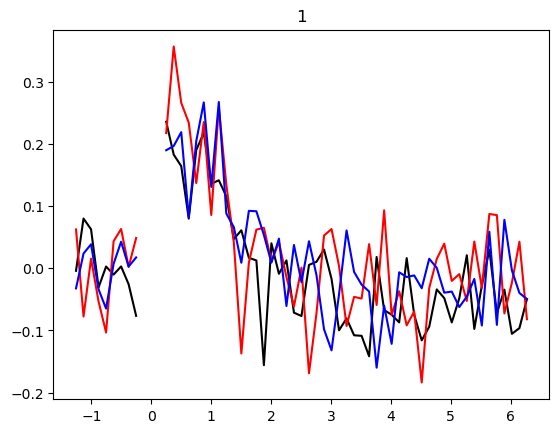

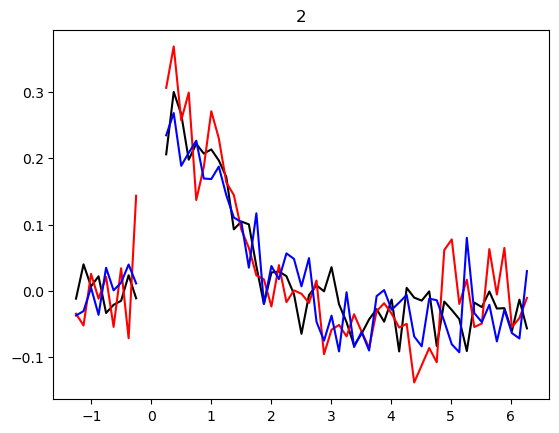

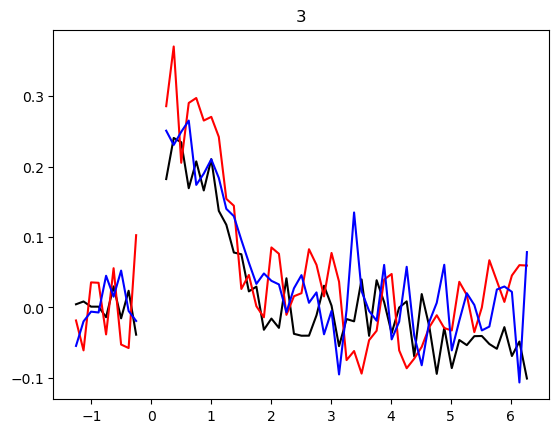

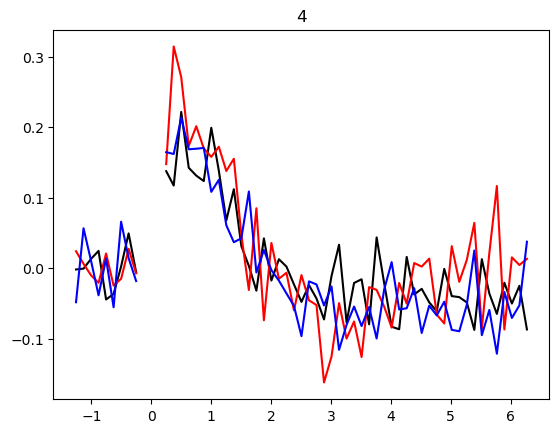

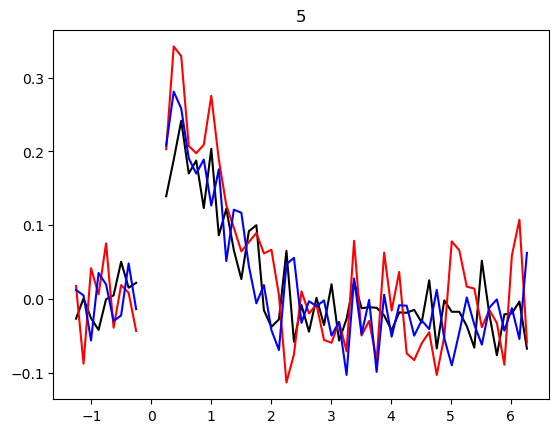

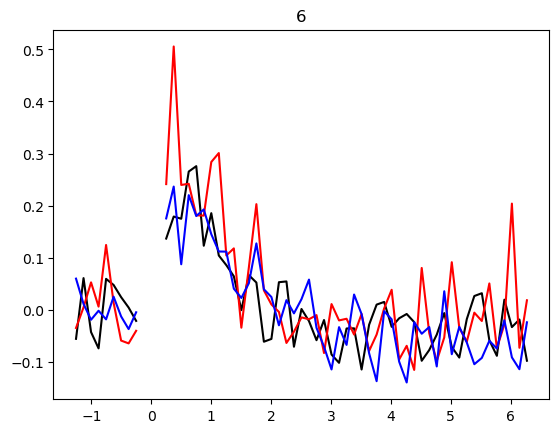

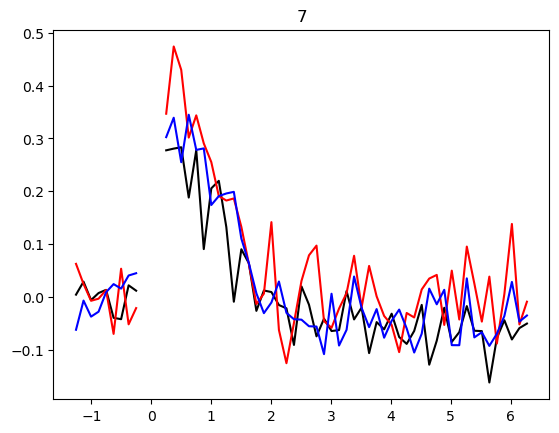

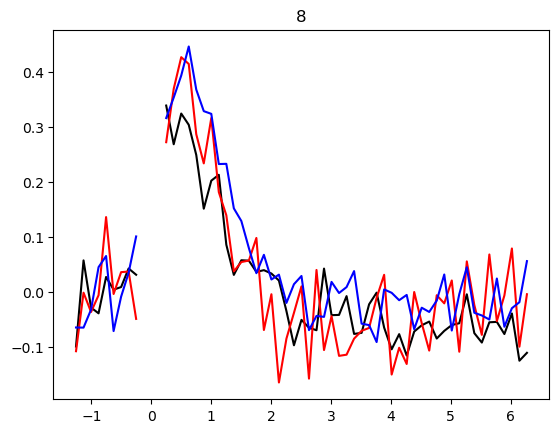

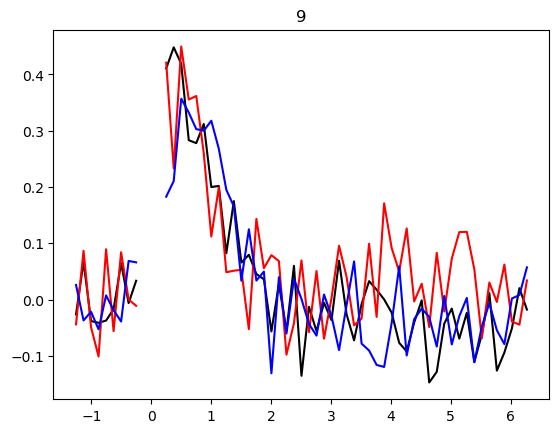

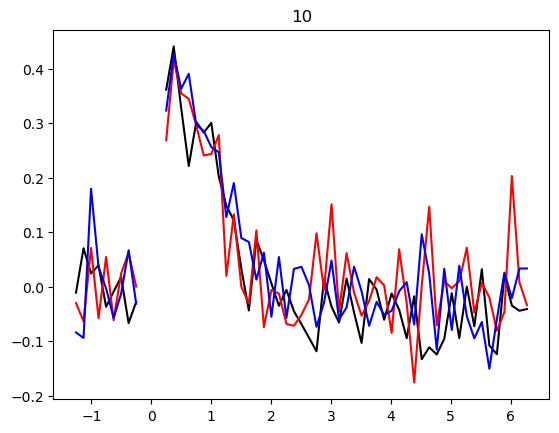

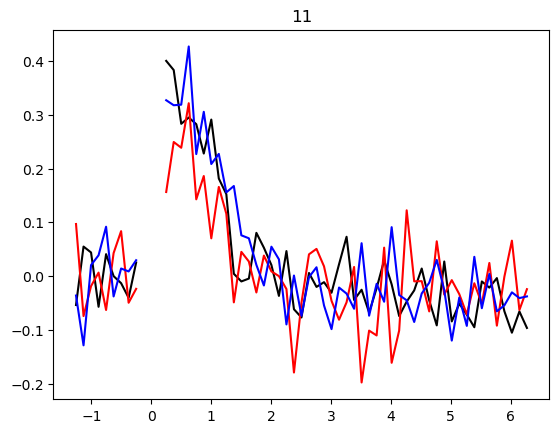

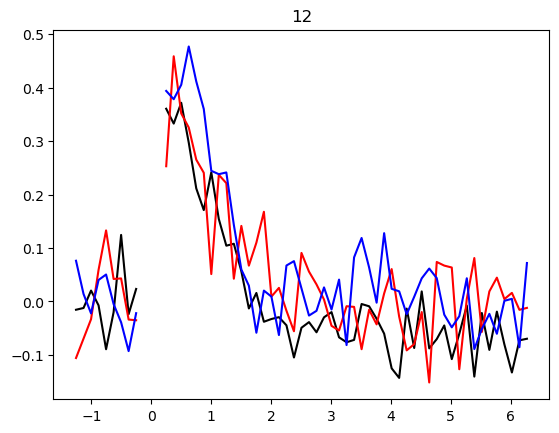

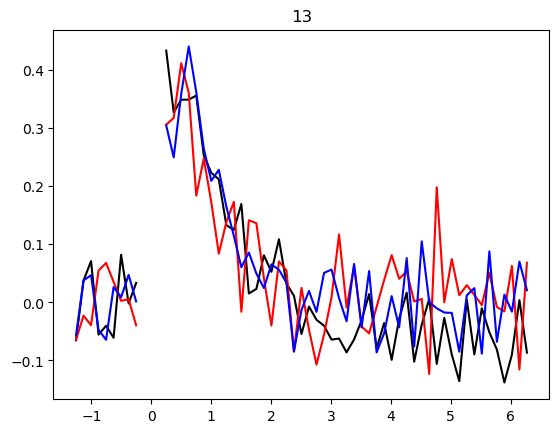

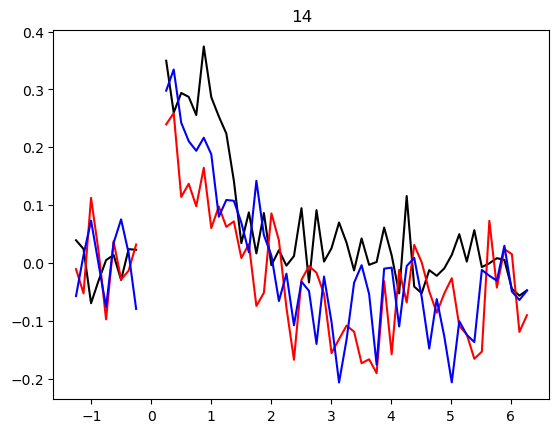

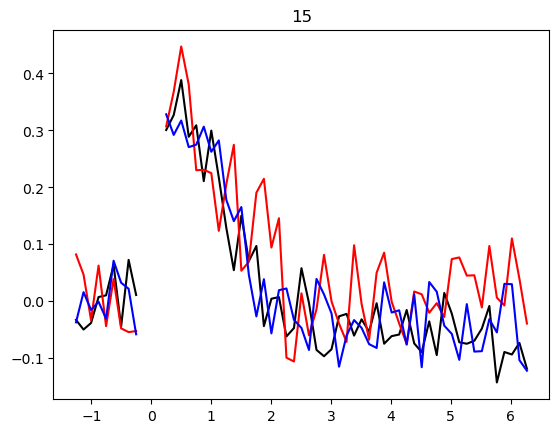

In [14]:
for roi in range(n_rois):
    fig, ax = plt.subplots()
    ax.plot(t, pre_resp[:,roi,:].mean(axis=0), color='black')
    ax.plot(t, pair_resp[:,roi,:].mean(axis=0), color='red')
    ax.plot(t, post_resp[:,roi,:].mean(axis=0), color='blue')
    ax.set_title(f'{roi}')

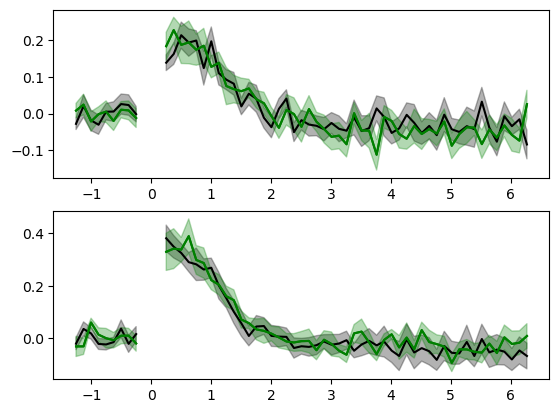

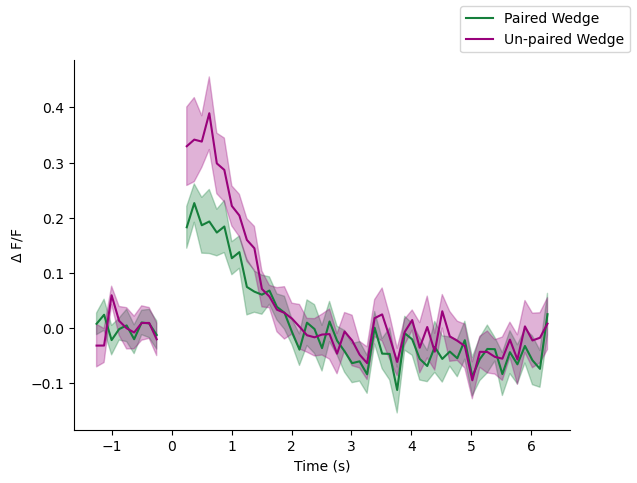

In [22]:
in_pump_path = [ 4,5,6]
out_pump_path = [10, 11, 12, 13, 14]


# fig, ax = plt.subplots(3,1)
# ax[0].plot(t, pre_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color='green')
# ax[0].plot(t, pre_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color='black')

# ax[1].plot(t, pair_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color='green')
# ax[1].plot(t, pair_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color='black')

# ax[2].plot(t, post_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color='green')
# ax[2].plot(t, post_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color='black')

fig, ax = plt.subplots(2,1)
mu, sem = pre_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), sp.stats.sem(pre_resp[:,in_pump_path,:].mean(axis=1),axis=0)
ax[0].plot(t, pre_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color='black')
ax[0].fill_between(t, mu-sem, mu+sem, alpha=.3, color='black')

mu, sem = post_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), sp.stats.sem(post_resp[:,in_pump_path,:].mean(axis=1),axis=0)
ax[0].plot(t, post_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color='green')
ax[0].fill_between(t, mu-sem, mu+sem, alpha=.3, color='green')
ax[0].plot(t, post_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color='green')

mu, sem = pre_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), sp.stats.sem(pre_resp[:,out_pump_path,:].mean(axis=1),axis=0)
ax[1].plot(t, pre_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color='black')
ax[1].fill_between(t, mu-sem, mu+sem, alpha=.3, color='black')

mu, sem = post_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), sp.stats.sem(post_resp[:,out_pump_path,:].mean(axis=1),axis=0)
ax[1].plot(t, post_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color='green')
ax[1].fill_between(t, mu-sem, mu+sem, alpha=.3, color='green')
ax[1].plot(t, post_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color='green')



fig, ax = plt.subplots()

mu, sem = post_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), sp.stats.sem(post_resp[:,in_pump_path,:].mean(axis=1),axis=0)
ax.plot(t, post_resp[:,in_pump_path,:].mean(axis=0).mean(axis=0), color=plt.cm.Greens(.8), label='Paired Wedge')
ax.fill_between(t, mu-sem, mu+sem, alpha=.3, color=plt.cm.Greens(.8))




mu, sem = post_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), sp.stats.sem(post_resp[:,out_pump_path,:].mean(axis=1),axis=0)
ax.plot(t, post_resp[:,out_pump_path,:].mean(axis=0).mean(axis=0), color=plt.cm.RdPu(.8), label='Un-paired Wedge')
ax.fill_between(t, mu-sem, mu+sem, alpha=.3, color=plt.cm.RdPu(.8))
fig.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel(r"$\Delta$ F/F")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/ex_vivo_pilot/puff_response.pdf')